In [1]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

# Works best with multiply RBF kernels at var=0.05, 0.1, 0.5, 1.
import gym
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler

In [2]:
class SGDRegressor:
    def __init__(self, D):
        self.w = np.random.randn(D) / np.sqrt(D)
        self.lr = 0.1
        
        
    def partial_fit(self, X, Y):
        # one step of gradient descent
        self.w += self.lr*(Y - X.dot(self.w)).dot(X)
        
    def predict(self, X):
        return X.dot(self.w)

In [3]:
class FeatureTransformer:
    def __init__(self, env):
        # generation of examples to train the FeatureTransformer
        # observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
        # NOTE!! state samples ar poor, b/c you get velocities --> infinity
        observation_samples = np.random.random((20000, 4))*2 - 1
        scaler = StandardScaler()
        scaler.fit(observation_samples)
        
        # Used to converte a state to a featurizes representation.
        # We use RBF kernels with different variances to cover different parts of the space
        featurizer = FeatureUnion([
            ("rbf1", RBFSampler(gamma= 0.05, n_components= 1000)),
            ("rbf2", RBFSampler(gamma= 1.0, n_components= 1000)),
            ("rbf3", RBFSampler(gamma= 0.5, n_components= 1000)),
            ("rbf4", RBFSampler(gamma= 0.1, n_components= 1000))
        ])
        example_features = featurizer.fit_transform(scaler.transform(observation_samples))
        
        self.dimensions = example_features.shape[1]
        self.scaler = scaler
        self.featurizer = featurizer
        
    def transform(self, observations):
        # print "observations:", observations
        scaled = self.scaler.transform(observations)
        # assert(len(scaled.shape) == 2)
        return self.featurizer.transform(scaled)

In [4]:
# Holds one SGDRegressor for each action
class Model:
    def __init__(self, env, feature_transformer):
        self.env = env
        self.models = []
        self.feature_transformer = feature_transformer
        # create a model by action
        for i in range(env.action_space.n):
            model = SGDRegressor(feature_transformer.dimensions)
            self.models.append(model)
            
    def predict(self, s):
        X = self.feature_transformer.transform(np.atleast_2d(s))
        assert(len(X.shape) == 2)
        return np.array([m.predict(X)[0] for m in self.models])
    
    def update(self, s, a, G):
        X = self.feature_transformer.transform(np.atleast_2d(s))
        assert(len(X.shape) == 2)
        # update the model of the action a
        self.models[a].partial_fit(X, [G])
        
    def sample_action(self, s, eps):
        if np.random.random() < eps:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.predict(s))

In [5]:
# return a list of states_and_rewards, and the total reward
def play_one(env, model, eps, gamma):
    observation = env.reset()
    done = False
    totalreward = 0
    iters = 0
    
    while not done and iters < 2000:
        # if we reach 2000, just quit, don't want this going forever
        # the 200 limit seems a bit early
        action = model.sample_action(observation, eps)
        prev_observation = observation
        observation, reward, done, info = env.step(action)
        
        if done:
            reward = -200
        
        # update the model
        next = model.predict(observation)
        assert(len(next.shape) == 1)
        G = reward + gamma*np.max(next)
        model.update(prev_observation, action, G)
        
        if reward == 1: # if we change the reward to -200
            totalreward += reward
        iters += 1
        
    return totalreward

In [6]:
def plot_running_avg(totalrewards):
    N = len(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = totalrewards[max(0, t-100): (t+1)].mean()
    plt.plot(running_avg)
    plt.title("Running Average")
    plt.show()
    

In [7]:
def main():
    env = gym.make('CartPole-v0')
    ft = FeatureTransformer(env)
    model = Model(env, ft)
    # learning_rate = 10e-5
    # eps = 1.0
    gamma = 0.99
    
    if 'monitor' in sys.argv:
        filename = os.path.basename(__file__).split('.')[0]
        monitor_dir = './' + filename + '_' + str(datetime.now())
        env = wrappers.Monitor(env, monitor_dir)
        
    N = 500
    totalrewards = np.empty(N)
    for n in range(N):
        # eps = 1.0/(0.1*n+1)
        # eps = 0.1*(0.97**n)
        eps = 1.0/np.sqrt(n+1)
        totalreward = play_one(env, model, eps, gamma)
        totalrewards[n] = totalreward
        if n % 100 == 0:
            print("episode:", n, "total reward:", totalreward, "eps:", eps, "avg reward (last 100):", totalrewards[max(0, n-100):(n+1)].mean())
            
    print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
    print("total steps:", totalrewards.sum())
    
    plt.plot(totalrewards)
    plt.title("Rewards")
    plt.show()
    
    plot_running_avg(totalrewards)

episode: 0 total reward: 12.0 eps: 1.0 avg reward (last 100): 12.0
episode: 100 total reward: 195.0 eps: 0.099503719021 avg reward (last 100): 95.9801980198
episode: 200 total reward: 76.0 eps: 0.0705345615859 avg reward (last 100): 146.267326733
episode: 300 total reward: 170.0 eps: 0.0576390417704 avg reward (last 100): 157.0
episode: 400 total reward: 199.0 eps: 0.0499376169439 avg reward (last 100): 163.594059406
avg reward for last 100 episodes: 162.55
total steps: 72462.0


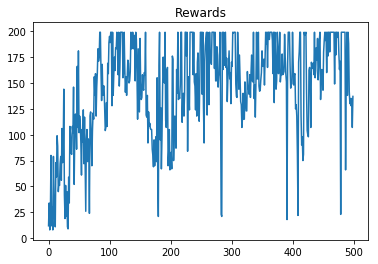

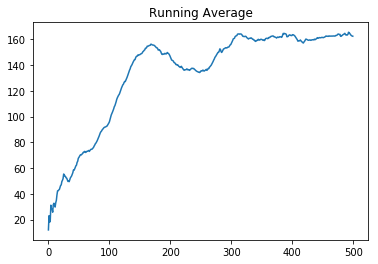

In [8]:
if __name__ == '__main__':
    main()